In [1369]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cp

In [1371]:
# SHV - rfr 

In [1373]:
data_desc = pd.read_excel("./data/multi_asset_etf_data.xlsx","descriptions",index_col=0)
data_price = pd.read_excel("./data/multi_asset_etf_data.xlsx","prices",index_col=0)
data_totalret = pd.read_excel("./data/multi_asset_etf_data.xlsx","total returns",index_col=0)
data_excessret = pd.read_excel("./data/multi_asset_etf_data.xlsx","excess returns",index_col=0)

# 2. MVO

## 1. Summary Statistics

In [1377]:
# Annualize the mean of monthly returns with a scaling of 12.
# Annualize the volatility of monthly returns with a scaling of 
# The Sharpe Ratio is the mean return divided by the volatility of returns. Accordingly, we can annualize the Sharpe Ratio with a scaling of 
# Note that we are not scaling the raw timeseries data, just the statistics computed from it (mean, vol, Sharpe).

In [1379]:
data_price_copy = data_price.copy()
data_price_copy.resample("ME") # price monthly resampling
data_mon_ret = (data_price_copy.pct_change().dropna()) # monthly returns 
data_mon_eret = data_mon_ret.sub(data_mon_ret['SHV'],axis=0).drop(columns= ['SHV']) # monthly excess returns

In [1381]:
def summary_statistics(df,period): # monthly_data annualized
    mean = df.mean()*period
    std = df.std()*np.sqrt(period)
    sharpe = mean / std

    summary_df = pd.DataFrame({"mean":mean,"std":std,"sharpe":sharpe})
    return summary_df.sort_values(by='sharpe',ascending=False)

In [1383]:
ss_df = summary_statistics(data_mon_eret,12)
print(ss_df)
print("Best Sharpe: {}:{} , Worst Sharpe {}:{}".format(ss_df['sharpe'].idxmax(),ss_df['sharpe'].max(),ss_df['sharpe'].idxmin(),ss_df['sharpe'].min()))

         mean       std    sharpe
SPY  0.126983  0.143066  0.887578
HYG  0.037356  0.077289  0.483335
IYR  0.077912  0.169585  0.459426
PSP  0.092851  0.215238  0.431386
EFA  0.055037  0.152203  0.361605
TIP  0.016844  0.051258  0.328618
QAI  0.014959  0.049007  0.305241
IEF  0.013939  0.063197  0.220561
EEM  0.026960  0.179940  0.149829
DBC -0.009086  0.168455 -0.053935
BWX -0.011888  0.081671 -0.145563
Best Sharpe: SPY:0.887578019353992 , Worst Sharpe BWX:-0.14556321071253217


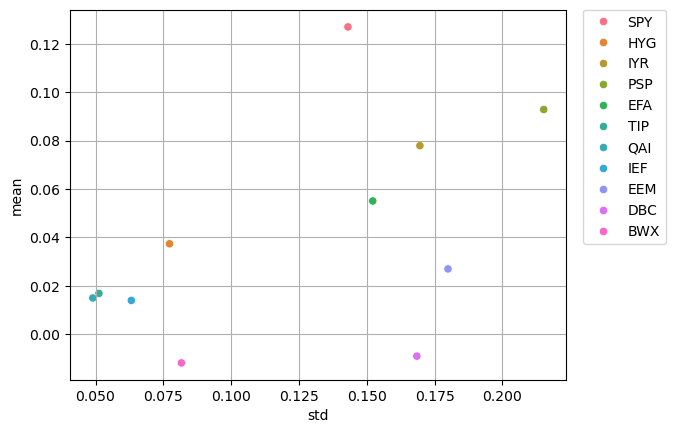

In [1385]:
sns.scatterplot(x='std',y='mean',hue= ss_df.index, data = ss_df)
plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
plt.grid(True)

## 2. Descriptive Analysis

<Axes: >

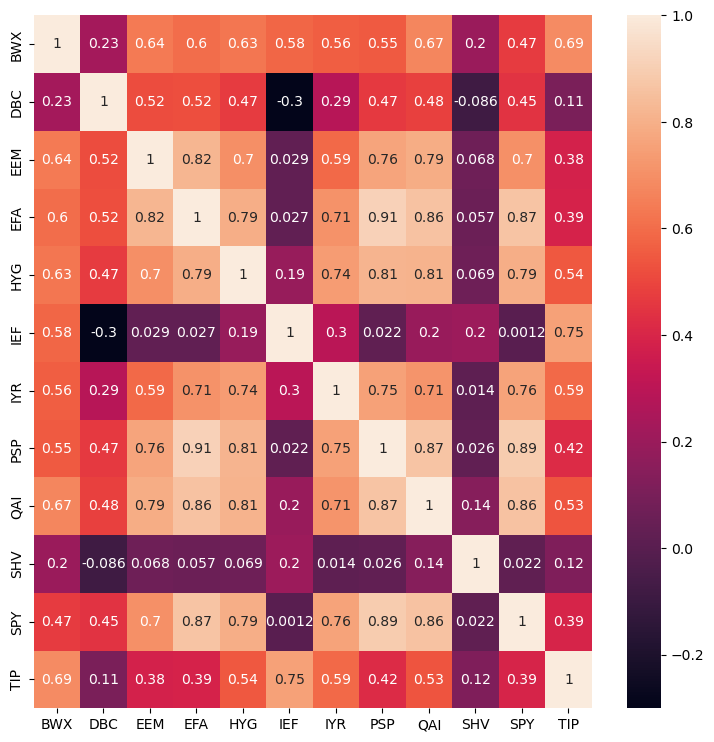

In [1388]:
plt.figure(figsize=(9,9))
sns.heatmap(data_mon_ret.corr(),annot=True)

In [1389]:
max_corr_idx, max_corr_col = np.unravel_index(np.argmax(data_mon_ret.corr().replace(1,-np.inf)),shape = data_mon_ret.corr().shape)
min_corr_idx, min_corr_col = np.unravel_index(np.argmin(data_mon_ret.corr()),shape = data_mon_ret.corr().shape)

print("Highest Correlation: {}-{}:{} , Highest Correlation {}-{}:{}".format(data_mon_ret.corr().index[max_corr_idx],data_mon_ret.corr().columns[max_corr_col],data_mon_ret.corr().values[max_corr_idx,max_corr_col],\
data_mon_ret.corr().index[min_corr_idx],data_mon_ret.corr().columns[min_corr_col],data_mon_ret.corr().values[min_corr_idx,min_corr_col])                                                                          )

Highest Correlation: EFA-PSP:0.9104796158129009 , Highest Correlation DBC-IEF:-0.30067500389044177


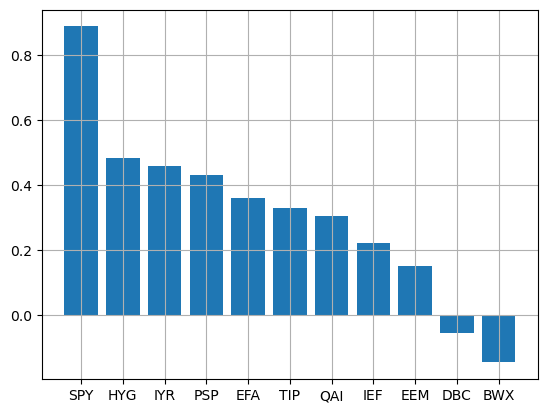

In [1392]:
plt.bar(ss_df.index,ss_df['sharpe'])
plt.grid(True) 
# BWX : Foreign bond
# IEF / HYG : Domestic bond ; IEF: mid-term treasury bond /HYG: high-yield treasury bond
# In terms of Sharpe, TIPs outperforms foreign bond and IEF(domestic bond) but not HYG(domestic bond)

## 3. The MV frontier

In [1395]:
def mvo_performance(weight,mean,cov):
    pfo_mean = weight.T @ mean
    pfo_std = np.sqrt(weight.T @ cov @ weight)
    pfo_sharpe = pfo_mean/pfo_std
    
    return pfo_mean, pfo_std, pfo_sharpe 
    
def tangency_weights(mean,cov):
    weight = (1/ (np.ones(cov.shape[0]).T@np.linalg.inv(cov)@ mean))*(np.linalg.inv(cov) @ mean)
    return weight

In [1397]:
def risky_portfolio(df,target): # efficient frontier
    n = df.shape[1]
    w= cp.Variable(n)
    cov = df.cov().values
    constraints = [w.T @ df.mean().values == target,
              cp.sum(w)==1]
    problem = cp.Problem(cp.Minimize(cp.quad_form(w,cov)),constraints)
    problem.solve()

    return np.sqrt(problem.value),w.value

In [1399]:
target_means= np.linspace(-0.1,0.1,1000)
vol = np.array([])
weights = np.array([])
for i in target_means: 
    std, w = risky_portfolio(data_mon_ret.drop(columns=['SHV']),i)
    vol = np.append(vol,std)
    weights = np.append(weights,w)

In [1400]:
tangency_weight = tangency_weights(data_mon_eret.mean(),data_mon_eret.cov())
print(pd.Series(tangency_weight,index= data_mon_eret.columns))

BWX    2.730253
DBC   -0.111241
EEM   -0.615698
EFA    0.530692
HYG   -0.832578
IEF   -4.682480
IYR    0.877108
PSP    0.277002
QAI    7.220592
SPY   -4.904086
TIP    0.510436
dtype: float64


In [1403]:
tangency_mean,tangency_std,tangency_sharpe=  mvo_performance(tangency_weight,data_mon_eret.mean().values,data_mon_eret.cov().values)

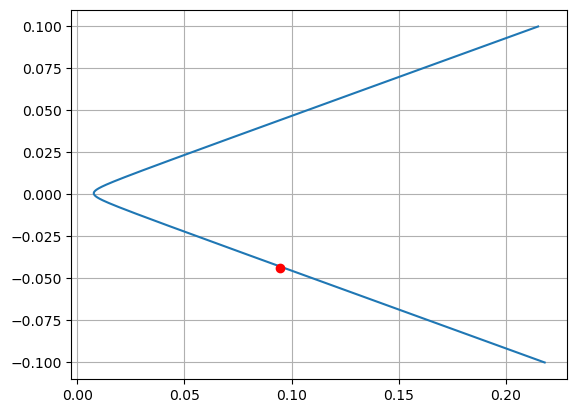

In [1405]:
plt.plot(vol,target_means)
plt.plot(tangency_std,tangency_mean,'ro')
plt.grid(True)

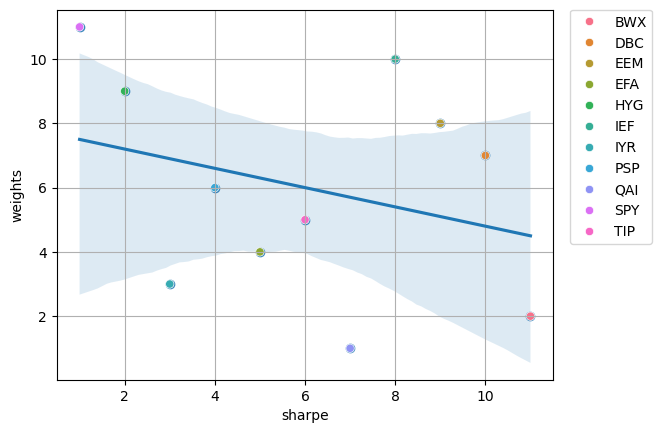

In [1407]:
weights_sr_comp = pd.concat([tangent_weights.rank(ascending=False),sharpe.rank(ascending=False)],axis=1,keys=['weights','sharpe'])
# sns.scatterplot(x='sharpe',y='weights',hue= weights_sr_comp.index, data = weights_sr_comp)
sns.regplot(data=weights_sr_comp, x="sharpe", y="weights")
sns.scatterplot(x='sharpe',y='weights',hue= weights_sr_comp.index, data = weights_sr_comp)
plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
plt.grid(True)

## 4. TIPS

In [1363]:
data_mon_eret.mean()[:-1].values

array([-0.00099069, -0.00075713,  0.00224668,  0.00458644,  0.00311303,
        0.00116156,  0.00649263,  0.00773755,  0.00124657,  0.01058189])

In [ ]:
def tangency_weights(mean,cov):
    weight = (1/ (np.ones(cov.shape[0]).T@np.linalg.inv(cov)@ mean))*(np.linalg.inv(cov) @ mean)
    return weight

In [1427]:
data_mon_eret.drop(columns=['TIP']).mean().values

array([-0.00099069, -0.00075713,  0.00224668,  0.00458644,  0.00311303,
        0.00116156,  0.00649263,  0.00773755,  0.00124657,  0.01058189])

In [1435]:
tips_ex_tangency_weights = tangency_weights(data_mon_eret.mean()[:-1].values,data_mon_eret.cov().iloc[:-1:,:-1].values)
tips_ex_tangency_mean = data_mon_eret.drop(columns=['TIP']).mean().values
tips_ex_tangency_std = data_mon_eret.drop(columns=['TIP']).cov().values
tips_ex_tangency_mean, tips_ex_tangency_std, tips_ex_tangency_sharpe = mvo_performance(tips_ex_tangency_weights,tips_ex_tangency_mean,tips_ex_tangency_std)

alt_eret = data_mon_eret.copy()
shift = 0.0012
alt_eret['TIP']+= shift
alt_eret_tangency_mean = alt_eret.drop(columns=['TIP']).mean().values
alt_eret_tangency_std = alt_eret.drop(columns=['TIP']).cov().values
alt_eret_tangency_weights = tangency_weights(alt_eret_tangency_mean,alt_eret_tangency_std)
alt_eret_tangency_mean, alt_eret_tangency_std, alt_eret_tangency_sharpe = mvo_performance(alt_eret_tangency_weights,alt_eret_tangency_mean,alt_eret_tangency_std)


In [1445]:
pd.DataFrame({"tangency":[tangency_mean,tangency_std,tangency_sharpe],"w/o TIPS":[tips_ex_tangency_mean, tips_ex_tangency_std, tips_ex_tangency_sharpe],\
"shifted":[alt_eret_tangency_mean, alt_eret_tangency_std, alt_eret_tangency_sharpe]},index=['mean','std','sharpe'])

,tangency,w/o TIPS,shifted
mean,-0.043940,-0.048400,-0.048400
std,0.094834,0.104536,0.104536
sharpe,-0.463334,-0.463001,-0.463001


# 3. Allocations

In [1459]:
target_mean = 0.01
mean = data_mon_eret.mean().values
cov = data_mon_eret.cov().values
std = data_mon_eret.std().values

ew = [1/data_mon_eret.shape[1]] * data_mon_eret.shape[1]
rpw = ((1/std**2) /np.sum((1/std**2)))
cov_reg = (cov+ np.diag(std))/2
w_reg = np.linalg.inv(cov_reg)*(np.matrix(mean).T)/np.sum(np.linalg.inv(cov_reg)*(np.matrix(mean).T))

In [927]:
def summary_statistics_annualized(returns, annual_factor = 12):
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    return summary_statistics


In [1475]:
weights_df = pd.DataFrame(columns=['tangency', 'equal', 'risk_parity', 'regularized'])
weights_df['tangency'] = tangency_weight
weights_df['equal'] = ew 
weights_df['risk_parity'] = rpw 
weights_df['regularized'] = w_reg 
weights_df.index = data_mon_eret.columns 


display(summary_statistics_annualized(data_mon_excessret@weights_df))

,Mean,Vol,Sharpe
tangency,-0.527276,0.328513,-1.605037
equal,0.040170,0.097588,0.411625
risk_parity,0.021787,0.056196,0.387703
regularized,0.077642,0.116814,0.664658
